In [1]:
%load_ext watermark
%watermark -a 'Niko' -v -p torch

Author: Niko

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.31.0

torch: 1.10.0



### Most Basic Graph Neural Network with Gaussian Filter on MNIST

A very basic graph neural network (GNN) implementation using a Gaussian Filter.

<br>Here, the $28$ x $28$ image of a digit in MNIST represents the graph, where each pixel (i.e., cell in the grid) represents a particular node. The feature of that node is simply the pixel intensity in range $[0, 1]$.

<br>The adjacency matrix of the pixels is basically just determined by their neighborhood pixels. Using a Gaussian filter, we connect pixels based on their Euclidean distance in grid.

<br>Using this adjacency matrix $A$, we can compute the output of a layer as
\begin{align*}
X^{(l+1)} = AX^{(l)}W^{(l)}
\end{align*}

Here, $A$ is the $N$ x $N$ adjacency matrix, and $X$ is the $N$ x $C$ feature matrix (a 2D coordinate array, where $N$ is the total number of pixels -- $28$ x $28$ $= 784$ in MNIST).
$W$ is the weight matrix of shape $N$ x $P$, where $P$ would present the number of classes if we have only a single hidden layer.

In [2]:
# Import libraries
import time, torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Subset
from scipy.spatial.distance import cdist

import warnings, copy
warnings.filterwarnings('ignore')

if torch.cuda.is_available(): 
    torch.backends.cudnn.deterministic = True

%matplotlib inline

In [3]:
# Setting device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setting hyper-parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0005
NUM_EPOCHS = 20
BATCH_SIZE = 128
IMG_SIZE = 28

### MNIST Dataset

In [4]:
custom_transfrom = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="./data", train=True, transform=custom_transfrom, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=custom_transfrom, download=True)

In [5]:

# mean, std = torch.zeros(3), torch.zeros(3)
# for img, label in train_dataset:
#     mean += torch.mean(img, dim=(1, 2))
#     std  += torch.std(img, dim=(1, 2))
    
# mean /= len(train_dataset)
# std /= len(train_dataset)

# mean, std

In [6]:
SPLIT_RATIO = 0.9 # 90% for training, 10% for valid
train_samples_num = int(len(train_dataset) * SPLIT_RATIO)
val_samples_num = len(train_dataset) - train_samples_num

train_dataset, val_dataset = random_split(train_dataset, [train_samples_num, val_samples_num])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

# Check the dataset
for images, labels in train_loader:
    print('Image batch dimension: ', images.shape)
    print('Image label dimension: ', labels.shape)
    break

Image batch dimension:  torch.Size([128, 1, 28, 28])
Image label dimension:  torch.Size([128])


### Building Model

In [7]:
def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    
    # N = img_size x img_size
    # Construct a 2D coordinate array (shape N x 2) and normalize to range (0, 1)
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size

    # Compute pairwise distance matrix (N x N)
    dist = cdist(coord, coord, metric='euclidean')

    # Apply Gaussian Filter
    sigma = 0.05 * np.pi
    A = np.exp(-dist / sigma**2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()

    # Normalization as per (Kipf & Welling, ICLR 2017)
    D = A.sum(1) # nodes degree (N,)
    D_hat = (D + 1e-5)**(-0.5)
    A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)

    return A_hat

torch.Size([784, 784])


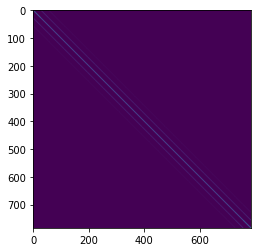

In [8]:
A_hat = precompute_adjacency_matrix(28)
plt.imshow(precompute_adjacency_matrix(28))
plt.show()

In [9]:
# Graph Model

class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super(GraphNet, self).__init__()

        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)
        A = precompute_adjacency_matrix(img_size=img_size)
        self.register_buffer('A', A)

    def forward(self, x):
        B = x.size(0) # Batch size

        # Reshape Adjacency Matrix
        # [N, N] Adjacency. matrix -> [1, N, N] Adjacency tensor where N = H x W
        A_tensor = self.A.unsqueeze(0)
        A_tensor = self.A.expand(B, -1, -1)

        # Reshape inputs
        # [B, C, H, W] -> [B, HxW, 1]
        x_reshape = x.view(B, -1, 1)

        # bmm: batch matrix product to sum the neighbor features
        # Input: [B, N, N] x [B, N, 1]
        # Output: [B, N]
        avg_neighbor_features = torch.bmm(A_tensor, x_reshape).view(B, -1)
        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [10]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=10)
model = model.to(DEVICE)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
def compute_acc(model, dataloader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in dataloader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, pred_labels = torch.max(probas, 1)
        num_examples += features.size(0)
        correct_pred += (pred_labels == targets).sum()
    return correct_pred.float() / num_examples * 100

In [12]:
start_time = time.time()

loss_list = []
train_acc_list, val_acc_list, test_acc_list = [], [], []

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward and back-propagation
        logits, probas = model(features)
        loss = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        # Update model parameters
        optimizer.step()
        loss_list.append(loss.item())

        if not batch_idx % 150:
            print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} |"
                    f"Batch: {batch_idx:03d}/{len(train_loader):03d} |"
                    f"Loss: {loss:.4f}")
    model.eval()
    with torch.no_grad():
        train_acc = compute_acc(model, train_loader, DEVICE)
        val_acc   = compute_acc(model, val_loader, DEVICE)
        test_acc  = compute_acc(model, test_loader, DEVICE)

        print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n"
                f"Train Accuracy: {train_acc:.2f} | Valid Accuracy: {val_acc:.2f} | Test Accuracy: {test_acc:.2f}")

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)

    elapsed = (time.time() - start_time) / 60
    print(f"Time elapsed: {elapsed:.2f} min")

elapsed = (time.time() - start_time) / 60
print(f"Total Training Time: {elapsed:.2f} min")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 001/020 |Batch: 000/422 |Loss: 2.2829
Epoch: 001/020 |Batch: 150/422 |Loss: 1.0369
Epoch: 001/020 |Batch: 300/422 |Loss: 0.7906


  5%|▌         | 1/20 [00:05<01:52,  5.91s/it]

Epoch: 001/020
Train Accuracy: 86.39 | Valid Accuracy: 86.15 | Test Accuracy: 87.35
Time elapsed: 0.10 min
Epoch: 002/020 |Batch: 000/422 |Loss: 0.6440
Epoch: 002/020 |Batch: 150/422 |Loss: 0.4777
Epoch: 002/020 |Batch: 300/422 |Loss: 0.5582


 10%|█         | 2/20 [00:12<01:49,  6.06s/it]

Epoch: 002/020
Train Accuracy: 88.68 | Valid Accuracy: 88.20 | Test Accuracy: 89.43
Time elapsed: 0.20 min
Epoch: 003/020 |Batch: 000/422 |Loss: 0.4412
Epoch: 003/020 |Batch: 150/422 |Loss: 0.3303
Epoch: 003/020 |Batch: 300/422 |Loss: 0.4011


 15%|█▌        | 3/20 [00:18<01:43,  6.11s/it]

Epoch: 003/020
Train Accuracy: 89.61 | Valid Accuracy: 89.30 | Test Accuracy: 90.34
Time elapsed: 0.30 min
Epoch: 004/020 |Batch: 000/422 |Loss: 0.5181
Epoch: 004/020 |Batch: 150/422 |Loss: 0.3627
Epoch: 004/020 |Batch: 300/422 |Loss: 0.3162


 20%|██        | 4/20 [00:24<01:38,  6.13s/it]

Epoch: 004/020
Train Accuracy: 90.29 | Valid Accuracy: 89.95 | Test Accuracy: 90.91
Time elapsed: 0.41 min
Epoch: 005/020 |Batch: 000/422 |Loss: 0.4025
Epoch: 005/020 |Batch: 150/422 |Loss: 0.2191
Epoch: 005/020 |Batch: 300/422 |Loss: 0.3186


 25%|██▌       | 5/20 [00:30<01:33,  6.21s/it]

Epoch: 005/020
Train Accuracy: 90.52 | Valid Accuracy: 90.42 | Test Accuracy: 90.96
Time elapsed: 0.51 min
Epoch: 006/020 |Batch: 000/422 |Loss: 0.5199
Epoch: 006/020 |Batch: 150/422 |Loss: 0.3385
Epoch: 006/020 |Batch: 300/422 |Loss: 0.3322


 30%|███       | 6/20 [00:37<01:27,  6.24s/it]

Epoch: 006/020
Train Accuracy: 90.90 | Valid Accuracy: 90.83 | Test Accuracy: 91.07
Time elapsed: 0.62 min
Epoch: 007/020 |Batch: 000/422 |Loss: 0.3949
Epoch: 007/020 |Batch: 150/422 |Loss: 0.3057
Epoch: 007/020 |Batch: 300/422 |Loss: 0.2952


 35%|███▌      | 7/20 [00:43<01:21,  6.25s/it]

Epoch: 007/020
Train Accuracy: 90.97 | Valid Accuracy: 90.92 | Test Accuracy: 91.33
Time elapsed: 0.72 min
Epoch: 008/020 |Batch: 000/422 |Loss: 0.2930
Epoch: 008/020 |Batch: 150/422 |Loss: 0.3168
Epoch: 008/020 |Batch: 300/422 |Loss: 0.2676


 40%|████      | 8/20 [00:49<01:15,  6.29s/it]

Epoch: 008/020
Train Accuracy: 91.34 | Valid Accuracy: 91.17 | Test Accuracy: 91.44
Time elapsed: 0.83 min
Epoch: 009/020 |Batch: 000/422 |Loss: 0.3424
Epoch: 009/020 |Batch: 150/422 |Loss: 0.2425
Epoch: 009/020 |Batch: 300/422 |Loss: 0.2092


 45%|████▌     | 9/20 [00:55<01:08,  6.26s/it]

Epoch: 009/020
Train Accuracy: 91.32 | Valid Accuracy: 91.22 | Test Accuracy: 91.45
Time elapsed: 0.93 min
Epoch: 010/020 |Batch: 000/422 |Loss: 0.2701
Epoch: 010/020 |Batch: 150/422 |Loss: 0.2744
Epoch: 010/020 |Batch: 300/422 |Loss: 0.4493


 50%|█████     | 10/20 [01:02<01:03,  6.36s/it]

Epoch: 010/020
Train Accuracy: 91.50 | Valid Accuracy: 91.35 | Test Accuracy: 91.66
Time elapsed: 1.04 min
Epoch: 011/020 |Batch: 000/422 |Loss: 0.2879
Epoch: 011/020 |Batch: 150/422 |Loss: 0.2380
Epoch: 011/020 |Batch: 300/422 |Loss: 0.2628


 55%|█████▌    | 11/20 [01:08<00:57,  6.37s/it]

Epoch: 011/020
Train Accuracy: 91.68 | Valid Accuracy: 91.65 | Test Accuracy: 91.85
Time elapsed: 1.15 min
Epoch: 012/020 |Batch: 000/422 |Loss: 0.2677
Epoch: 012/020 |Batch: 150/422 |Loss: 0.3194
Epoch: 012/020 |Batch: 300/422 |Loss: 0.2545


 60%|██████    | 12/20 [01:15<00:51,  6.38s/it]

Epoch: 012/020
Train Accuracy: 91.74 | Valid Accuracy: 91.58 | Test Accuracy: 91.84
Time elapsed: 1.25 min
Epoch: 013/020 |Batch: 000/422 |Loss: 0.2277
Epoch: 013/020 |Batch: 150/422 |Loss: 0.3411
Epoch: 013/020 |Batch: 300/422 |Loss: 0.3349


 65%|██████▌   | 13/20 [01:21<00:44,  6.41s/it]

Epoch: 013/020
Train Accuracy: 91.75 | Valid Accuracy: 91.78 | Test Accuracy: 91.89
Time elapsed: 1.36 min
Epoch: 014/020 |Batch: 000/422 |Loss: 0.2703
Epoch: 014/020 |Batch: 150/422 |Loss: 0.3937
Epoch: 014/020 |Batch: 300/422 |Loss: 0.2035


 70%|███████   | 14/20 [01:28<00:38,  6.38s/it]

Epoch: 014/020
Train Accuracy: 91.88 | Valid Accuracy: 91.87 | Test Accuracy: 92.07
Time elapsed: 1.47 min
Epoch: 015/020 |Batch: 000/422 |Loss: 0.2302
Epoch: 015/020 |Batch: 150/422 |Loss: 0.2065
Epoch: 015/020 |Batch: 300/422 |Loss: 0.2855


 75%|███████▌  | 15/20 [01:34<00:31,  6.39s/it]

Epoch: 015/020
Train Accuracy: 91.87 | Valid Accuracy: 91.75 | Test Accuracy: 92.04
Time elapsed: 1.57 min
Epoch: 016/020 |Batch: 000/422 |Loss: 0.3235
Epoch: 016/020 |Batch: 150/422 |Loss: 0.3023
Epoch: 016/020 |Batch: 300/422 |Loss: 0.1407


 80%|████████  | 16/20 [01:40<00:25,  6.34s/it]

Epoch: 016/020
Train Accuracy: 92.00 | Valid Accuracy: 91.97 | Test Accuracy: 92.13
Time elapsed: 1.68 min
Epoch: 017/020 |Batch: 000/422 |Loss: 0.3441
Epoch: 017/020 |Batch: 150/422 |Loss: 0.4426
Epoch: 017/020 |Batch: 300/422 |Loss: 0.2778


 85%|████████▌ | 17/20 [01:46<00:18,  6.32s/it]

Epoch: 017/020
Train Accuracy: 92.06 | Valid Accuracy: 91.88 | Test Accuracy: 92.15
Time elapsed: 1.78 min
Epoch: 018/020 |Batch: 000/422 |Loss: 0.3392
Epoch: 018/020 |Batch: 150/422 |Loss: 0.2329
Epoch: 018/020 |Batch: 300/422 |Loss: 0.2620


 90%|█████████ | 18/20 [01:53<00:12,  6.27s/it]

Epoch: 018/020
Train Accuracy: 92.01 | Valid Accuracy: 91.90 | Test Accuracy: 92.14
Time elapsed: 1.89 min
Epoch: 019/020 |Batch: 000/422 |Loss: 0.3693
Epoch: 019/020 |Batch: 150/422 |Loss: 0.3408
Epoch: 019/020 |Batch: 300/422 |Loss: 0.2758


 95%|█████████▌| 19/20 [01:59<00:06,  6.26s/it]

Epoch: 019/020
Train Accuracy: 92.08 | Valid Accuracy: 92.03 | Test Accuracy: 92.27
Time elapsed: 1.99 min
Epoch: 020/020 |Batch: 000/422 |Loss: 0.2823
Epoch: 020/020 |Batch: 150/422 |Loss: 0.2575
Epoch: 020/020 |Batch: 300/422 |Loss: 0.2671


100%|██████████| 20/20 [02:05<00:00,  6.29s/it]

Epoch: 020/020
Train Accuracy: 92.11 | Valid Accuracy: 92.23 | Test Accuracy: 92.32
Time elapsed: 2.10 min
Total Training Time: 2.10 min


### Evaluation

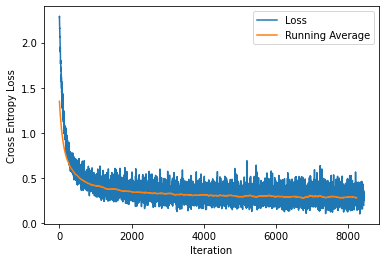

In [13]:
plt.plot(loss_list, label='Loss')
plt.plot(np.convolve(loss_list, np.ones(200,) / 200, mode='valid'), label='Running Average')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()


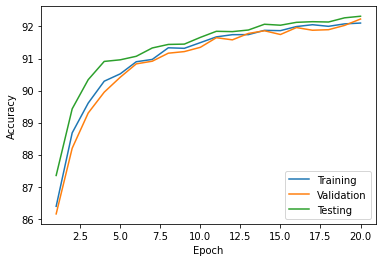

In [14]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), val_acc_list, label='Validation')
plt.plot(np.arange(1, NUM_EPOCHS+1), test_acc_list, label='Testing')
plt.xlabel('Epoch')# last adjacency matrix
plt.ylabel('Accuracy')
plt.legend()
plt.show()